### 1 导入数据分析相关的库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.ensemble import RandomForestRegressor  #随机森林回归
from sklearn.ensemble import GradientBoostingRegressor  #梯度提升回归
from sklearn.svm import SVR  #支持向量机回归
import lightgbm as lgb  #LightGBM
from xgboost import XGBRegressor  #XGBoost
from sklearn.model_selection import learning_curve  # 用于学习曲线绘制
from sklearn.model_selection import ShuffleSplit  # 用于数据集划分
from sklearn.model_selection import train_test_split  # 用于数据集划分
from sklearn.metrics import mean_squared_error  #均方误差
import warnings

from crawler.基础知识.第二节.market import title

warnings.filterwarnings('ignore')

### 2 数据加载

##### 2.1 未降维数据

In [5]:
all_data = pd.read_csv('./processed_zhengqi_data.csv')

# 训练数据
cond1 = all_data['label'] == 'train'
train_data = all_data[cond1]
train_data.drop(labels=['label'], axis=1, inplace=True)
# 切分数据
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(labels=['target'], axis=1), train_data['target'],
                                                      test_size=0.2)
# 测试数据
cond2 = all_data['label'] == 'test'
test_data = all_data[cond2]
test_data.drop(labels=['label', 'target'], axis=1, inplace=True)

##### 2.2 降维数据

In [6]:
# 采用pca保留特征的数据
train_data_pca = np.load('./train_data_pca.npz')['X_train']
target_data_pca = np.load('./train_data_pca.npz')['y_train']
# 切分数据
X_train_pca, X_valid_pca, y_train_pca, y_valid_pca = train_test_split(train_data_pca, target_data_pca, test_size=0.2)
test_data_pca = np.load('./test_data_pca.npz')['X_test']

array([[-4.11871585e-01, -1.08188853e-01, -4.27745048e-01, ...,
         4.44593521e-01, -2.45417729e-01, -5.42400841e-01],
       [-3.44356864e-01,  2.38917329e-01, -3.76115824e-01, ...,
        -2.11927243e-01, -4.27776541e-01, -6.88479573e-01],
       [-8.39614579e-01,  9.49047588e-01, -3.59670949e-01, ...,
        -1.92410111e-04, -6.98947700e-01, -1.11982217e+00],
       ...,
       [-3.09839870e+00, -5.93275480e-01, -1.13652847e+00, ...,
        -4.34570482e-01,  9.19849176e-02, -5.31788055e-02],
       [-3.02283260e+00, -6.21423917e-01, -1.15209458e+00, ...,
         1.14202697e-01, -2.60199572e-01,  8.22175523e-02],
       [-2.93166281e+00, -7.27660619e-01, -1.16166067e+00, ...,
         2.16275970e-01,  1.24102165e+00, -2.14447273e+00]],
      shape=(1925, 22))

### 3 定义绘制模型学习曲线的函数

In [16]:
def plot_learn_curve(model, title, X, y, cv=None):
    """
    绘制模型学习曲线
    :param model: 模型
    :param title: 标题
    :param X: 特征
    :param y: 标签
    :param cv: 交叉验证划分器
    """

    # 学习曲线
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    # 计算训练集和测试集的平均分数和标准差
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 训练数据得分可视化
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="r")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    # 测试数据得分可视化
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")

    # 画图设置
    plt.grid()  # 网格
    plt.legend(loc="best")
    plt.title(title)  # 标题
    plt.xlabel("Training examples")  # x轴标签
    plt.ylabel("Score")  # y轴标签

### 4 多元线性回归

##### 4.1 模型训练

In [8]:
# 降维数据建模验证
clf = LinearRegression()
clf.fit(X_train_pca, y_train_pca)
score = mean_squared_error(y_train_pca, clf.predict(X_train_pca))
print("LinearRegression train score: ", score)

LinearRegression train score:  0.10704046264610516


In [9]:
# 未降维数据建模验证
clf = LinearRegression()
clf.fit(X_train, y_train)
score = mean_squared_error(y_train, clf.predict(X_train))
print("LinearRegression train score: ", score)

LinearRegression train score:  0.10350830543953701


##### 4.2 模型学习曲线

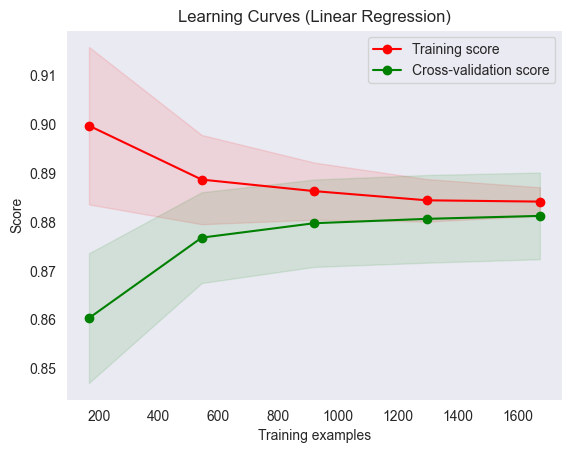

In [19]:
# 降维数据学习曲线
X = X_train_pca
y = y_train_pca
title = "Learning Curves (Linear Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
estimator = LinearRegression()  # 线性回归模型
plot_learn_curve(estimator, title, X, y, cv=cv)
plt.savefig("./多元线性回归降维数据学习曲线.png", dpi=300, bbox_inches='tight')

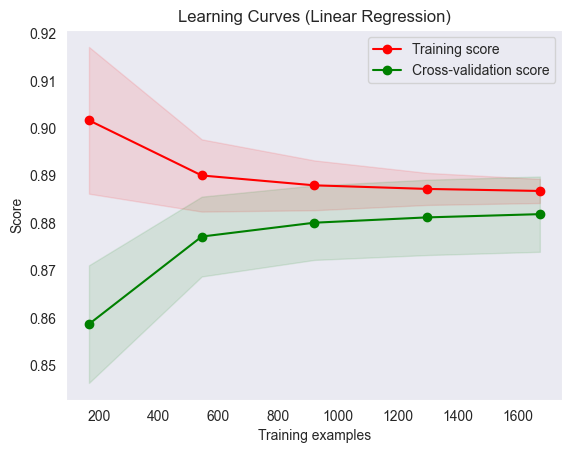

In [20]:
# 未降维数据学习曲线
X = X_train
y = y_train
title = "Learning Curves (Linear Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.25, random_state=0)
estimator = LinearRegression()  # 线性回归模型
plot_learn_curve(estimator, title, X, y, cv=cv)
plt.savefig("./多元线性回归未降维数据学习曲线.png", dpi=300, bbox_inches='tight')